# **Final Project (section 5 - tumors)**

In [52]:
import os
import sys
import cv2
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import csv
import random

## 5.1 Preparing Data

Load Source Dataset (done locally)

In [53]:
np.set_printoptions(threshold=sys.maxsize)

In [14]:
rgb_dir = os.path.join('QC', "rgb")
mask_dir = os.path.join('QC', "mask")
csv_dir = os.path.join('QC', "csv")

image_files = os.listdir(rgb_dir)
mask_files = os.listdir(mask_dir)
csv_files = os.listdir(csv_dir)

image_files.sort()
mask_files.sort()
csv_files.sort()

5.1.1  Convert Image and Masks to Grayscale

In [122]:
def loadGray(id):
    image_path = os.path.join(rgb_dir, id)
    image = cv2.imread(image_path + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #plt.imshow(mask, cmap = 'gray')

    mask_path = os.path.join(mask_dir, id)
    mask = cv2.imread(mask_path + '.png')
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    #plt.imshow(mask, cmap = 'gray')
    
    print(mask.shape)
    print(image.shape)

    return image, mask


5.1.2.  Multiply the Mask and the original to obtain regions of interest

In [191]:
def ROI(image, mask):
    # Ensure the mask and image are the same size
    min_height = min(image.shape[0], mask.shape[0])
    min_width = min(image.shape[1], mask.shape[1])

    image = image[:min_height, :min_width]  
    mask = mask[:min_height, :min_width]   

    # Threshold mask to find the actual ROI
    _, mask_binary = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)  # Ensure binary mask (0 or 255)

    # Find contours of the mask to get the actual ROI bounding box
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return np.zeros_like(image)  # Return an empty image if no mask is found

    # Get bounding box around the mask
    x, y, w, h = cv2.boundingRect(contours[0])

    # Crop to the actual mask region
    mask_cropped = mask_binary[y:y+h, x:x+w]

    # Normalize and apply mask
    mask_cropped = mask_cropped.astype(np.float32) / 255.0  # Normalize mask
    
    newMask = mask_cropped * (1-mask)
    
    roi = newMask * image

    return roi


5.1.3. Remove background noice

In [ ]:
def backgroundRemove(roi, mask):
    if roi.dtype != np.uint8:
        roi = (roi * 255).astype(np.uint8)
    
    _, binary_roi = cv2.threshold(roi, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    kernel = np.ones((3, 3), np.uint8)  # 3x3 kernel
    clean_roi = cv2.morphologyEx(binary_roi, cv2.MORPH_OPEN, kernel, iterations=2)
    
    clean_roi = cv2.medianBlur(clean_roi, 3)

    final_output = cv2.bitwise_and(roi, mask=clean_roi)


    return clean_roi


(369, 340)
(369, 340)


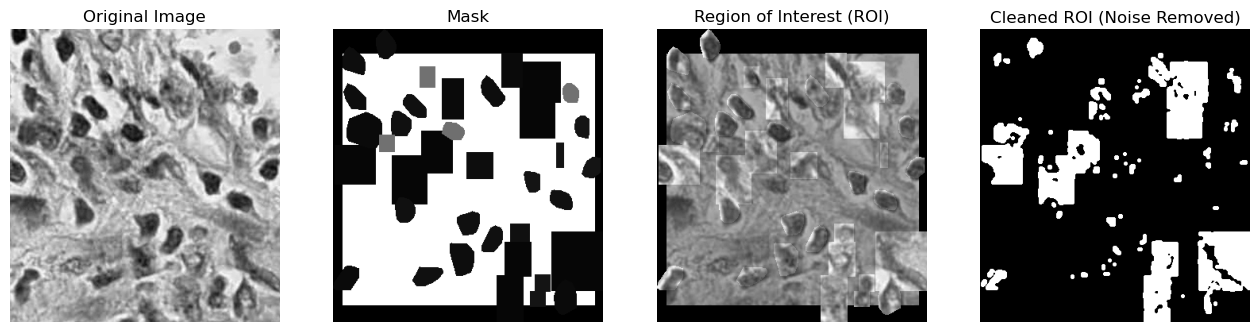

In [199]:
subject_id = "TCGA-A2-A0T0-DX1_id-5ea40989ddda5f839897f293_left-76950_top-61480_bottom-61778_right-77225"
image, mask = loadGray(subject_id)
roi = ROI(image,mask)
final = backgroundRemove(roi, mask)


# Display results
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Mask")
axs[1].axis("off")

axs[2].imshow(roi, cmap='gray')
axs[2].set_title("Region of Interest (ROI)")
axs[2].axis("off")

axs[3].imshow(final, cmap='gray')
axs[3].set_title("Cleaned ROI (Noise Removed)")
axs[3].axis("off")

plt.show()